  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  2254k      0  0:00:36  0:00:36 --:--:-- 2425k


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/413k [00:00<?, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Training model 1 with EMBED_DIM=128, NUM_LAYERS=1
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
At epoch 1: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('if'), np.str_('you'), np.str_('my')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 150s 175ms/step - loss: 7.2611
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
At epoch 2: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('my'), np.str_('it'), np.str_('the')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - loss: 6.6198
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
At epoch 3: 
Predicted tokens:  [np.str_('i'), np.str_('my'), np.str_('this'), np.str_('it'), np.str_('the')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - loss: 6.1247
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
At epoch 4: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('my'), np.str_('the'), np.str_('it')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - loss: 5.7020
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
At epoch 5: 
Predicted t

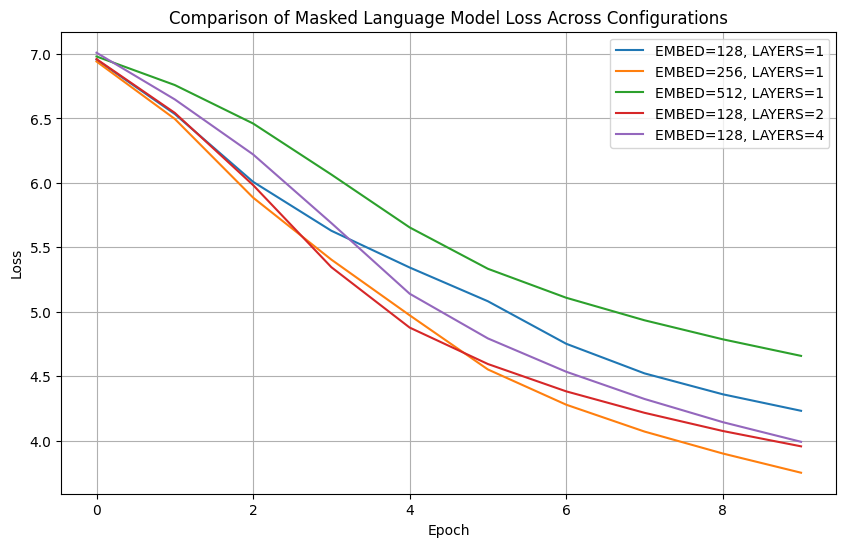

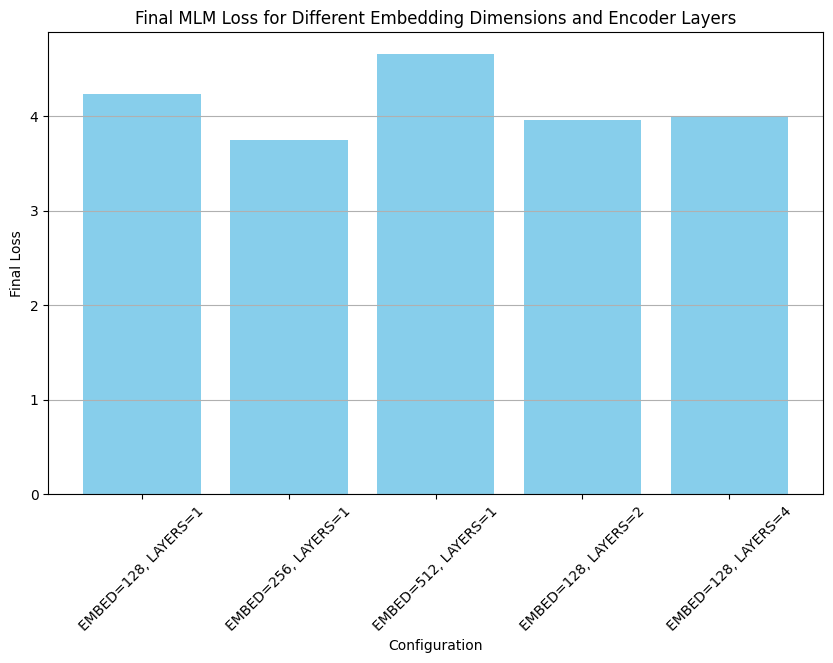


Model Architecture Diagrams (Simplified):

Config: EMBED_DIM=128, NUM_LAYERS=1
Input -> Embedding (dim=128)
  -> Encoder Block 1 (Multi-Head Attn: heads=8, FF Dim=128)
  -> MLM Head (Vocab Size=30000)

Config: EMBED_DIM=256, NUM_LAYERS=1
Input -> Embedding (dim=256)
  -> Encoder Block 1 (Multi-Head Attn: heads=8, FF Dim=256)
  -> MLM Head (Vocab Size=30000)

Config: EMBED_DIM=512, NUM_LAYERS=1
Input -> Embedding (dim=512)
  -> Encoder Block 1 (Multi-Head Attn: heads=8, FF Dim=512)
  -> MLM Head (Vocab Size=30000)

Config: EMBED_DIM=128, NUM_LAYERS=2
Input -> Embedding (dim=128)
  -> Encoder Block 1 (Multi-Head Attn: heads=8, FF Dim=128)
  -> Encoder Block 2 (Multi-Head Attn: heads=8, FF Dim=128)
  -> MLM Head (Vocab Size=30000)

Config: EMBED_DIM=128, NUM_LAYERS=4
Input -> Embedding (dim=128)
  -> Encoder Block 1 (Multi-Head Attn: heads=8, FF Dim=128)
  -> Encoder Block 2 (Multi-Head Attn: heads=8, FF Dim=128)
  -> Encoder Block 3 (Multi-Head Attn: heads=8, FF Dim=128)
  -> Encoder Bl

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # Change to "torch" or "jax" if preferred

import keras
from keras import layers
from keras.layers import TextVectorization
from keras.callbacks import EarlyStopping

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

# For data pre-processing and tf.data.Dataset (using TensorFlow for dataset handling)
import tensorflow as tf

# For plotting
import matplotlib.pyplot as plt

# Install required packages
!pip install -q transformers datasets evaluate

from datasets import load_dataset
import evaluate

@dataclass
class Config:
    MAX_LEN: int
    BATCH_SIZE: int
    LR: float
    VOCAB_SIZE: int
    EMBED_DIM: int
    NUM_HEAD: int
    FF_DIM: int
    NUM_LAYERS: int

# Define multiple configurations for comparison
configs = [
    Config(MAX_LEN=256, BATCH_SIZE=64, LR=0.001, VOCAB_SIZE=30000, EMBED_DIM=128, NUM_HEAD=8, FF_DIM=128, NUM_LAYERS=1),  # Base
    Config(MAX_LEN=256, BATCH_SIZE=64, LR=0.001, VOCAB_SIZE=30000, EMBED_DIM=256, NUM_HEAD=8, FF_DIM=256, NUM_LAYERS=1),  # Larger embedding
    Config(MAX_LEN=256, BATCH_SIZE=64, LR=0.001, VOCAB_SIZE=30000, EMBED_DIM=512, NUM_HEAD=8, FF_DIM=512, NUM_LAYERS=1),  # Even larger embedding
    Config(MAX_LEN=256, BATCH_SIZE=64, LR=0.001, VOCAB_SIZE=30000, EMBED_DIM=128, NUM_HEAD=8, FF_DIM=128, NUM_LAYERS=2),  # More layers
    Config(MAX_LEN=256, BATCH_SIZE=64, LR=0.001, VOCAB_SIZE=30000, EMBED_DIM=128, NUM_HEAD=8, FF_DIM=128, NUM_LAYERS=4),  # Even more layers
]

# Download and extract IMDB data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list

def get_data_from_text_files(folder_name):
    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df

train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = pd.concat([train_df, test_df])

# Load SNLI dataset for vectorization and fine-tuning
snli = load_dataset("snli")

# Convert to DataFrames and filter out label == -1
snli_train = pd.DataFrame(snli['train'])
snli_valid = pd.DataFrame(snli['validation'])
snli_test = pd.DataFrame(snli['test'])

snli_train = snli_train[snli_train['label'] != -1].reset_index(drop=True)
snli_valid = snli_valid[snli_valid['label'] != -1].reset_index(drop=True)
snli_test = snli_test[snli_test['label'] != -1].reset_index(drop=True)

# Collect texts for vectorization (IMDB reviews + SNLI premises and hypotheses)
snli_texts = snli_train['premise'].tolist() + snli_train['hypothesis'].tolist() + \
             snli_valid['premise'].tolist() + snli_valid['hypothesis'].tolist() + \
             snli_test['premise'].tolist() + snli_test['hypothesis'].tolist()
all_texts = all_data.review.values.tolist() + snli_texts

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, r"[!#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}~]", ""
    )

def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[cls]", "[sep]", "[mask]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert special tokens in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + special_tokens
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

# Functions remain the same
def encode(texts, config):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu", name="encoder_{}_ffn_dense_1".format(i)),
            layers.Dense(config.EMBED_DIM, name="encoder_{}_ffn_dense_2".format(i)),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output

def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction="none")
loss_tracker = keras.metrics.Mean(name="loss")

class MaskedLanguageModel(keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

def create_masked_language_bert_model(config):
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    embedding_layer = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding")(
        inputs
    )
    position_embedding = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = embedding_layer + position_embedding

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model

class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens) # Pass the sample tokens directly
        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[0]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        probabilities = mask_prediction[0][top_indices]
        predicted_tokens = [
            self.convert_ids_to_tokens(index) for index in top_indices
        ]
        print("At epoch %d: " % (epoch + 1))
        print("Predicted tokens: ", predicted_tokens)

# Global variables for vocabulary
vectorize_layer = get_vectorize_layer(
    all_texts,
    configs[0].VOCAB_SIZE,  # Assuming same vocab size
    configs[0].MAX_LEN,
    special_tokens=["[cls]", "[sep]", "[mask]"],
)
cls_token_id = vectorize_layer(["[cls]"]).numpy()[0][0]
sep_token_id = vectorize_layer(["[sep]"]).numpy()[0][0]
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}

# Prepare data once (using base config params)
x_all_review = encode(all_data.review.values, configs[0])
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(x_all_review)

# Histories for comparison
histories = []
labels = []

# Train and compare for each config
for idx, config in enumerate(configs):
    print(f"Training model {idx+1} with EMBED_DIM={config.EMBED_DIM}, NUM_LAYERS={config.NUM_LAYERS}")

    mlm_ds = tf.data.Dataset.from_tensor_slices(
        (x_masked_train, y_masked_labels, sample_weights)
    ).shuffle(1000).batch(config.BATCH_SIZE)

    sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
    generator_callback = MaskedTextGenerator(sample_tokens.numpy())

    bert_masked_model = create_masked_language_bert_model(config)

    mlm_history = bert_masked_model.fit(
        mlm_ds,
        epochs=10,
        callbacks=[generator_callback]
    )

    histories.append(mlm_history.history['loss'])
    labels.append(f"EMBED={config.EMBED_DIM}, LAYERS={config.NUM_LAYERS}")

# Plot comparison of MLM losses
plt.figure(figsize=(10, 6))
for i, loss in enumerate(histories):
    plt.plot(loss, label=labels[i])
plt.title('Comparison of Masked Language Model Loss Across Configurations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Bar plot for final losses
final_losses = [h[-1] for h in histories]
plt.figure(figsize=(10, 6))
plt.bar(labels, final_losses, color='skyblue')
plt.title('Final MLM Loss for Different Embedding Dimensions and Encoder Layers')
plt.xlabel('Configuration')
plt.ylabel('Final Loss')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Diagram: Simple text-based representation of model architectures
print("\nModel Architecture Diagrams (Simplified):")
for config in configs:
    print(f"\nConfig: EMBED_DIM={config.EMBED_DIM}, NUM_LAYERS={config.NUM_LAYERS}")
    print("Input -> Embedding (dim={})".format(config.EMBED_DIM))
    for i in range(config.NUM_LAYERS):
        print("  -> Encoder Block {} (Multi-Head Attn: heads={}, FF Dim={})".format(i+1, config.NUM_HEAD, config.FF_DIM))
    print("  -> MLM Head (Vocab Size={})".format(config.VOCAB_SIZE))